# Predicting Volatility and Sign of S&P Returns using LSTM

## Imports

In [173]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import math

In [174]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [175]:
df = pd.read_csv('monthly_FRED-MD_2024-12_processed.csv')
#df = df[["RPI", "IPFUELS", "PAYEMS", "UNRATE", "FEDFUNDS", "TB3MS", "CPIAUCSL", "HOUST", "GS10", "sign"]]

Applying PCA might help mitigate the multicollinearity of the data, but makes interpretation at the end harder.

In [176]:
# from sklearn.decomposition import PCA
# X = df.drop(columns=["sign", "volatility"]).values
# feature_names = list(df.drop(columns=["sign", "volatility"]).columns)
# pca = PCA()
# pca.fit(X)
# explained = pca.explained_variance_ratio_
# cum_explained = np.cumsum(explained)

# # number of components to explain 95% variance
# k95 = int(np.searchsorted(cum_explained, 0.95) + 1)
# print(f"Components to explain 95% variance: {k95} / {X.shape[1]}")

# X_pca_all = pca.transform(X)
# X_pca = X_pca_all[:, :k95]

# # optional: dataframe of PCs (index aligns with original df)
# pca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]
# pca_df = pd.DataFrame(X_pca, columns=pca_cols, index=df.index)

# df = pd.concat([pca_df, df[["sign", "volatility"]]], axis=1)

# print(pca_df.head())

## Hyperparameter

In [177]:
NUMBER_OF_LAGS = 10
TRAIN_RATIO = 0.8
HIDDEN_DIM = 16
NUM_LAYERS = 2
DROPOUT = 0.2
LR = 3e-4
BATCH_SIZE = 64
EPOCHS = 50
CLASS_THRESHOLD = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [179]:
# Keep only numeric features (drop target)
numeric = df.select_dtypes(include=[np.number]).copy()
X_all = numeric.drop(columns=["sign", "volatility"]).values
y_sign = numeric["sign"].astype(int).values
y_volatility = numeric["volatility"].astype(int).values

In [180]:
# Create sliding-window sequences
def create_sequences(X, y1, y2, window):
    Xs, ys, yv = [], [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i, :])
        ys.append(y1[i])
        yv.append(y2[i])
    return np.array(Xs), np.array(ys), np.array(yv)

X_seq, y_seq, yv_seq = create_sequences(X_all, y_sign, y_volatility, NUMBER_OF_LAGS)

In [181]:
if len(X_seq) == 0:
    raise ValueError("Not enough rows to create sequences with the chosen WINDOW_SIZE.")

## Train-Test Split

In [ ]:
train_size = int(len(X_seq) * TRAIN_RATIO)
X_train = X_seq[:train_size]; X_test = X_seq[train_size:]
ys_train = y_seq[:train_size]; ys_test = y_seq[train_size:]
yv_train = yv_seq[:train_size]; yv_test = yv_seq[train_size:]

In [183]:
# Torch datasets
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
ys_train_t = torch.tensor(ys_train, dtype=torch.float32).unsqueeze(1).to(device)
yv_train_t = torch.tensor(yv_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
ys_test_t = torch.tensor(ys_test, dtype=torch.float32).unsqueeze(1).to(device)
yv_test_t = torch.tensor(yv_test, dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_t, ys_train_t, yv_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

## LSTM Model

In [ ]:
class LSTMDoubleOutput(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # binary output (logit)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)  # logits (use BCEWithLogitsLoss)

input_dim = X_train.shape[2]
model = LSTMDoubleOutput(input_dim=input_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS).to(device)
criterion_sign = nn.BCEWithLogitsLoss()
criterion_volatility = nn.MSELoss()
lambda_volatility = 1 # weight for volatility loss

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Training Loop

In [ ]:
model.train()
for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    total_sign_loss = 0.0
    total_vol_loss = 0.0
    n = 0
    for Xb, yb_sign, yb_vol in train_loader:
        optimizer.zero_grad()
        out = model(Xb)                      # (batch,2)
        sign_logit = out[:, 0:1]
        vol_pred_z = out[:, 1:2]
        loss_sign = criterion_sign(sign_logit, yb_sign)
        loss_vol = criterion_volatility(vol_pred_z, yb_vol)
        loss = loss_sign + lambda_volatility * loss_vol
        loss.backward()
        optimizer.step()
        batch_n = Xb.size(0)
        total_loss += loss.item() * batch_n
        total_sign_loss += loss_sign.item() * batch_n
        total_vol_loss += loss_vol.item() * batch_n
        n += batch_n
    total_loss /= n
    total_sign_loss /= n
    total_vol_loss /= n
    if epoch % 10 == 0 or epoch == 1 or epoch == EPOCHS:
        print(f"Epoch {epoch}/{EPOCHS} - loss: {total_loss:.4f} | sign_loss: {total_sign_loss:.4f} | vol_loss: {total_vol_loss:.6f}")


Epoch 1/50 - loss: 1.2962 | sign_loss: 0.6910 | vol_loss: 0.605178
Epoch 10/50 - loss: 1.1506 | sign_loss: 0.6899 | vol_loss: 0.460720
Epoch 20/50 - loss: 1.0640 | sign_loss: 0.6884 | vol_loss: 0.375546
Epoch 30/50 - loss: 0.9879 | sign_loss: 0.6871 | vol_loss: 0.300786
Epoch 40/50 - loss: 0.9118 | sign_loss: 0.6860 | vol_loss: 0.225847
Epoch 50/50 - loss: 0.8560 | sign_loss: 0.6843 | vol_loss: 0.171744


## Evaluation

In [ ]:
model.eval()
with torch.no_grad():
    out_test = model(X_test_t)
    sign_logits_test = out_test[:, 0].cpu().numpy()
    sign_probs = torch.sigmoid(out_test[:, 0:1]).cpu().numpy().squeeze()
    sign_preds = (sign_probs > CLASS_THRESHOLD).astype(int)
    vol_preds = out_test[:, 1].cpu().numpy().squeeze()

In [187]:
# classification metrics
acc = accuracy_score(ys_test, sign_preds)
print(f"Test accuracy (sign): {acc:.4f}")
print("Classification report (sign):")
print(classification_report(ys_test, sign_preds, digits=4))

# regression metrics for volatility
rmse_vol = math.sqrt(mean_squared_error(ys_test, vol_preds))
print(f"Volatility RMSE (original units): {rmse_vol:.6f}")

Test accuracy (sign): 0.5962
Classification report (sign):
              precision    recall  f1-score   support

           0     0.3529    0.1034    0.1600        58
           1     0.6259    0.8878    0.7342        98

    accuracy                         0.5962       156
   macro avg     0.4894    0.4956    0.4471       156
weighted avg     0.5244    0.5962    0.5207       156

Volatility RMSE (original units): 0.678597


In [188]:
def count_parameters(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    print(f"Total params: {total:,} | Trainable params: {trainable:,}")

count_parameters(model)

print(f"Data points: {df.shape[0]*df.shape[1]}")

Total params: 10,594 | Trainable params: 10,594
Data points: 90735


Interpreting the output with Shap values

 16%|█▌        | 8/50 [00:00<00:03, 10.93it/s]C:\Users\jdobe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.105e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
 28%|██▊       | 14/50 [00:01<00:03, 11.00it/s]C:\Users\jdobe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than t

            variable  mean_abs_shap
49           HOUSTMW       0.001508
82            BAAFFM       0.001247
33     CES1021000001       0.001102
81            AAAFFM       0.000950
111         DTCTHFNM       0.000813
23            UNRATE       0.000811
60          TOTRESNS       0.000744
45           AWOTMAN       0.000721
46            AWHMAN       0.000699
55          ISRATIOx       0.000677
57              M2SL       0.000649
88        WPSFD49502       0.000618
104  DDURRG3M086SBEA       0.000613
18            CUMFNS       0.000602
10          IPNCONGD       0.000598
0                RPI       0.000590
14            IPNMAT       0.000579
71               GS5       0.000568
109    CES3000000008       0.000562
75         COMPAPFFx       0.000553


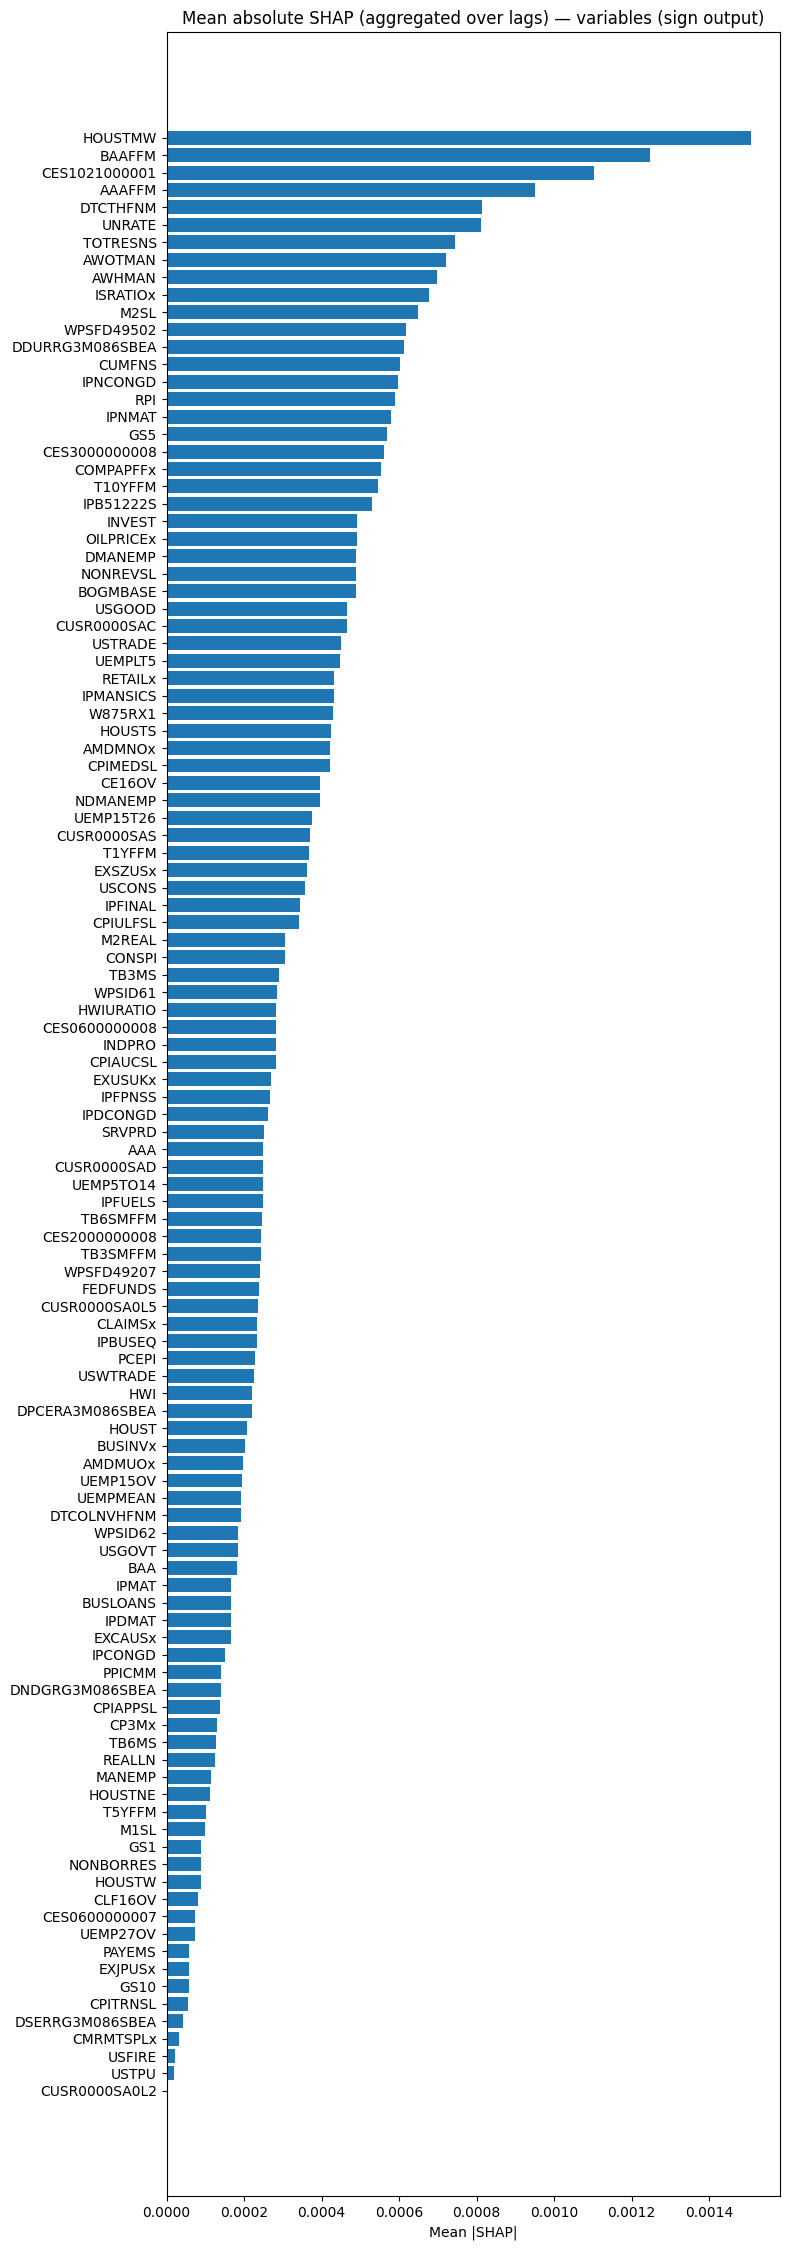

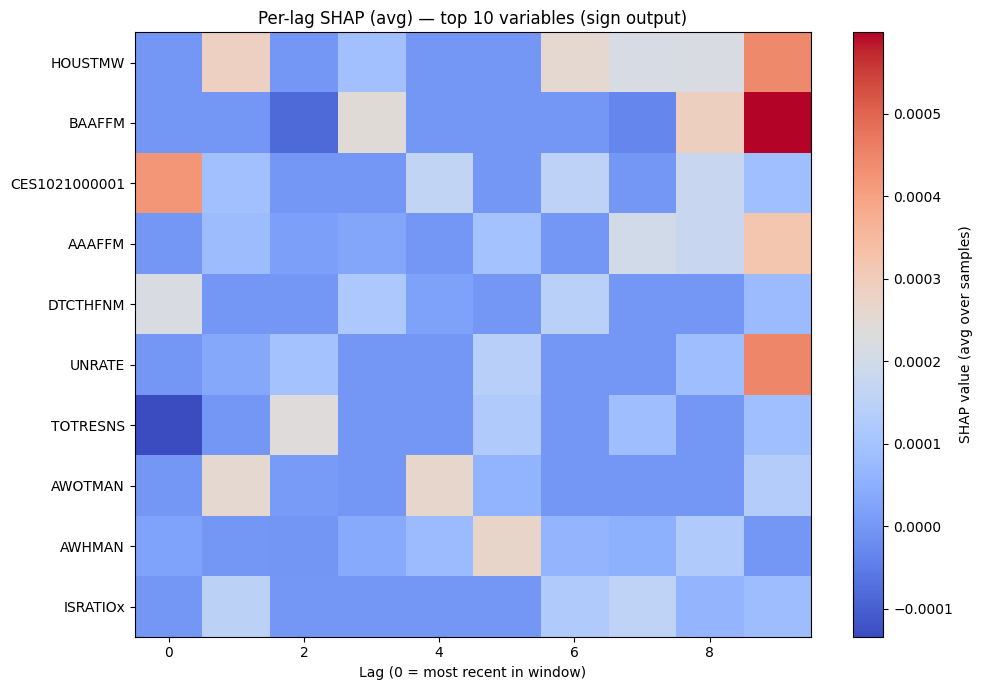

In [ ]:
import shap
import matplotlib.pyplot as plt

# configure sizes (reduce for speed)
N_BACKGROUND = min(100, X_train.shape[0])
N_EXPLAIN = min(50, X_test.shape[0])
NSAMPLES = 100  # KernelExplainer samples (increase for accuracy)

# feature names (original numeric columns without 'sign' and 'volatility')
feature_names = list(numeric.drop(columns=["sign", "volatility"]).columns)
input_dim = X_train.shape[2]
window = NUMBER_OF_LAGS

# prepare background and explain matrices (flatten time axis)
Xb = X_train[:N_BACKGROUND].reshape(N_BACKGROUND, -1)
Xexp = X_test[:N_EXPLAIN].reshape(N_EXPLAIN, -1)

# prediction function for SHAP: expects flattened numpy array -> returns 1D vector (sign probability)
def predict_sign_proba(X_flat):
    # X_flat shape: (m, window*input_dim) or (window*input_dim,) for single sample
    X = np.array(X_flat).reshape(-1, window, input_dim)
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        out = model(X_t)                  # (m, 2) or (m, n_outputs)
        sign_logit = out[:, 0:1]          # keep only sign head
        sign_prob = torch.sigmoid(sign_logit).cpu().numpy().squeeze()
    # ensure returned shape is (m,) for KernelExplainer
    return np.asarray(sign_prob).ravel()

# create explainer; use background Xb (numpy)
explainer = shap.KernelExplainer(predict_sign_proba, Xb)

# compute shap values for sign output
shap_vals_raw = explainer.shap_values(Xexp, nsamples=NSAMPLES)

# normalize shap output to array of shape (n_samples, n_features_flat)
if isinstance(shap_vals_raw, list):
    # KernelExplainer may return a list (one per model output/class); we only expect sign -> take first sensible element
    # possible shapes: [ (n_samples, n_features) ] or list of arrays -> take first
    shap_candidate = shap_vals_raw[0]
else:
    shap_candidate = shap_vals_raw
shap_flat = np.array(shap_candidate)

# sanity check
n_features_flat = window * input_dim
if shap_flat.ndim != 2 or shap_flat.shape[1] != n_features_flat:
    raise ValueError(f"Unexpected SHAP shape {shap_flat.shape}, expected (n_samples, {n_features_flat})")

# reshape to (n_samples, window, input_dim)
shap_arr = shap_flat.reshape(shap_flat.shape[0], window, input_dim)

# aggregate absolute contributions by variable (sum over lags, then mean over samples)
per_var_importance = np.mean(np.sum(np.abs(shap_arr), axis=1), axis=0)  # length = input_dim

# DataFrame and bar plot
imp_df = pd.DataFrame({
    "variable": feature_names,
    "mean_abs_shap": per_var_importance
}).sort_values("mean_abs_shap", ascending=False)

print(imp_df.head(20))

plt.figure(figsize=(8, max(4, 0.2 * len(imp_df))))
plt.barh(imp_df['variable'].iloc[::-1], imp_df['mean_abs_shap'].iloc[::-1])
plt.title('Mean absolute SHAP (aggregated over lags) — variables (sign output)')
plt.xlabel('Mean |SHAP|')
plt.tight_layout()
plt.show()

# Optional: per-lag heatmap for top K variables
TOP_K = 10
top_vars = imp_df['variable'].iloc[:TOP_K].values
top_idx = [feature_names.index(v) for v in top_vars]

# average SHAP across samples for chosen vars, shape (window, TOP_K)
shap_time_top = np.mean(shap_arr[:, :, top_idx], axis=0)  # (window, TOP_K)

plt.figure(figsize=(10, 4 + 0.3 * window))
plt.imshow(shap_time_top.T, aspect='auto', cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='SHAP value (avg over samples)')
plt.yticks(range(len(top_vars)), top_vars)
plt.xlabel('Lag (0 = most recent in window)')
plt.title(f'Per-lag SHAP (avg) — top {TOP_K} variables (sign output)')
plt.tight_layout()
plt.show()
# ...existing code...